In [165]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import joblib
import shap
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [166]:
# Load dataset
data = pd.read_csv("parkinsons.data")

# Display basic info
print(data.head())

             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.0654

In [167]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [168]:
# Check for missing values
print(data.isnull().sum())

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


In [169]:
# Drop non-feature columns (like 'name')
data = data.drop(columns=['name'])

# Split features and labels
X = data.drop(columns=['status'])  # Features
y = data['status']  # Target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [170]:
# Train an XGBoost model (NO SCALING)
xgb_model = xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [171]:
# Make predictions with XGBoost
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [172]:
# Evaluate the XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")
print(f"XGBoost ROC-AUC Score: {roc_auc_xgb:.2f}")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Accuracy: 0.95
XGBoost ROC-AUC Score: 0.93
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39

[[ 5  2]
 [ 0 32]]


In [174]:
# Save the trained XGBoost model
joblib.dump(xgb_model, 'parkinsons_xgb_model.pkl')

['parkinsons_xgb_model.pkl']

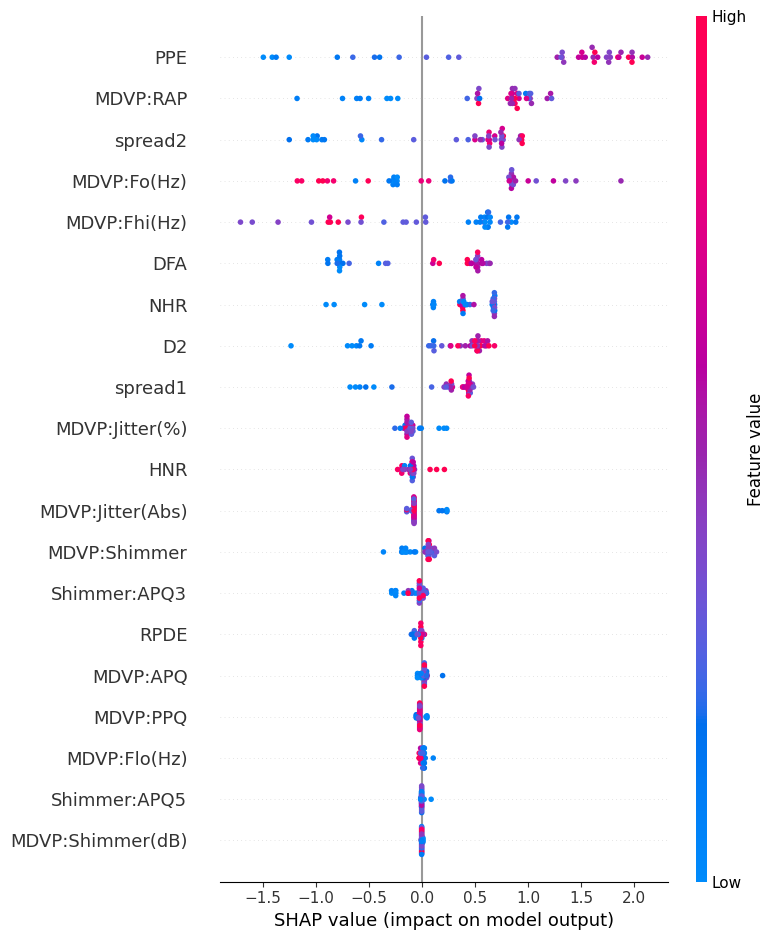

In [175]:
# Feature Importance with SHAP
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [176]:
# Convert SHAP values into a NumPy array
shap_features = shap_values.values

In [177]:
# Apply StandardScaler ONLY for Neural Network
scaler = StandardScaler()
shap_features_scaled = scaler.fit_transform(shap_features)

# Save scaler for future use
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [178]:
# Convert to PyTorch tensors
X_shap_train = torch.tensor(shap_features_scaled, dtype=torch.float32)
y_shap_train = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader for training
train_dataset = TensorDataset(X_shap_train, y_shap_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [179]:
# Define a Simple Neural Network
class ShapNN(nn.Module):
    def __init__(self, input_dim):
        super(ShapNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [180]:
# Initialize the model
input_dim = shap_features_scaled.shape[1]
shap_nn = ShapNN(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(shap_nn.parameters(), lr=0.001)

In [181]:
# Train the Neural Network
epochs = 100
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = shap_nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.6391
Epoch 10, Loss: 0.3874
Epoch 20, Loss: 0.1680
Epoch 30, Loss: 0.0959
Epoch 40, Loss: 0.3047
Epoch 50, Loss: 0.0083
Epoch 60, Loss: 0.0815
Epoch 70, Loss: 0.0098
Epoch 80, Loss: 0.0046
Epoch 90, Loss: 0.0124


In [182]:
# Evaluate the Neural Network
with torch.no_grad():
    y_pred_prob_shap_nn = shap_nn(X_shap_train).numpy().flatten()
    y_pred_shap_nn = (y_pred_prob_shap_nn > 0.5).astype(int)

In [183]:
# Compute metrics
accuracy_shap_nn = accuracy_score(y_test, y_pred_shap_nn)
roc_auc_shap_nn = roc_auc_score(y_test, y_pred_prob_shap_nn)

In [184]:
print(f"SHAP-Based Neural Network Accuracy: {accuracy_shap_nn:.2f}")
print(f"SHAP-Based Neural Network ROC-AUC Score: {roc_auc_shap_nn:.2f}")
print(classification_report(y_test, y_pred_shap_nn))
print(confusion_matrix(y_test, y_pred_shap_nn))

SHAP-Based Neural Network Accuracy: 1.00
SHAP-Based Neural Network ROC-AUC Score: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        32

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39

[[ 7  0]
 [ 0 32]]


In [185]:
# Save the SHAP-based NN model
torch.save(shap_nn.state_dict(), 'parkinsons_shap_nn.pth')